In [1]:
import json
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from scipy.optimize import minimize
from matplotlib import gridspec


In [2]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [3]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [5]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [6]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [7]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [8]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [9]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [58]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM#psiM.unit()
    return psiNorm


In [59]:
zeroVector = [2,0,0,0,0,0,0,0,0,0]
H=hamiltonian(N,B,A0)
#print(H)
psiM = RBM_ansatz(zeroVector,N, M)
print(psiM)
#E = expect(H,psiM)
#print(E)
#norm = psiM.norm()**2
#print(norm)
#Enorm = E/norm
#print(Enorm)
#varEnergy(zeroVector,N, M, H)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[5.43656366]
 [5.43656366]
 [0.73575888]
 [0.73575888]]


In [14]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [15]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [16]:
#Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [17]:
#NelderMead
class NelderMead:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='nelder-mead', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [18]:
#BFGS
class BFGS:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='BFGS', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [19]:
#Newton-CG
class NewtonCG:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='Newton-CG', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [20]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


In [21]:
#Loader to test different methods with same RBM initalization
def minLoader(minimizer, par, N, M, B, A0):
    if minimizer == 'GradDescent':
        gradDescent = GradDescent(N, B, A0)
        gd = gradDescent(N, M,par)
        return gd
    if minimizer == "NelderMead":
        nelderMead = NelderMead(N,B,A0)
        nm = nelderMead(N,M,par)
        return nm
    if minimizer == "BFGS":
        bfgs = BFGS(N,B,A0)
        bf = bfgs(N,M,par)
        return bf
        
        
    

## Same Starting Paramters

In [317]:
#Parameter definition 
N= 2
M=1
B = 1
A0 = 1


gdResults = [] #gives ground state estimation at each iteration of gd
gdState = []
gdTime = []
gdEngErr = []
gdStateErr = []

params = []
trained_params = []

edState = []
edTime = []
ActualEng = []
hisIt = np.arange(20)

In [318]:
for i in range(20):
    par = ranRBMpar(N,M)
    params.append(par)
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M,par)
    gdResults.append(gd)
    gdState.append(gd[0])
    gdTime.append(gd[1])
    trained_params.append(gd[0][0][0])


    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    edState.append(ed[0])
    edTime.append(ed[1])

    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    gdErrTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    gdEngErr.append(gdErrTemp[0])
    gdStateErr.append(gdErrTemp[1])

Optimization terminated successfully.
         Current function value: -0.750033
         Iterations: 6
         Function evaluations: 276
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -0.749925
         Iterations: 8
         Function evaluations: 312
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -0.957106
         Iterations: 27
         Function evaluations: 660
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: -0.957070
         Iterations: 44
         Function evaluations: 960
         Gradient evaluations: 80
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 25
         Function evaluations: 540
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: -0.957091
         Iterations: 90
         Function evaluatio

Text(0.5, 0, 'Run Number')

<Figure size 432x288 with 0 Axes>

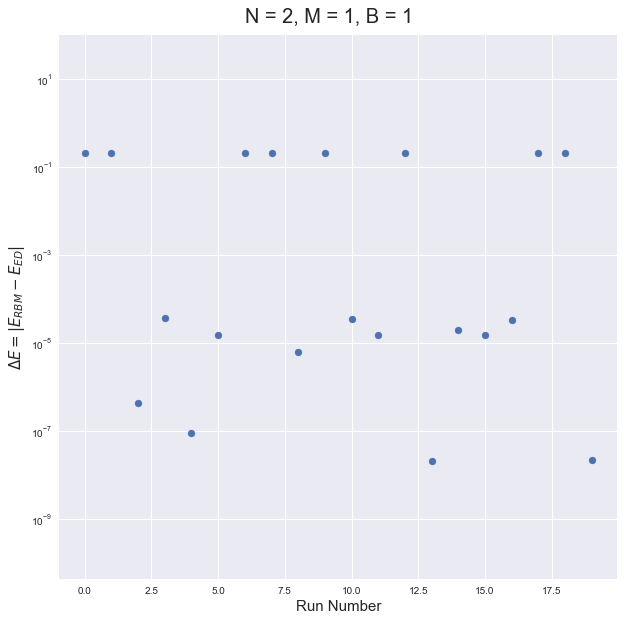

In [356]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, B = 1",size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.92])


ax4 = plt.subplot(gs[0, :])
ax4.set_yscale('log')
ax4.scatter(hisIt,gdEngErr) 
ax4 .set_ylabel("$\Delta E = |E_{RBM}-E_{ED}|$", size = 15)
ax4.set_xlabel("Run Number",size = 15)


In [351]:
steps = np.arange(100)
min1 = trained_params[0]
min2 = trained_params[5]
sub = min1-min2
stepDirections = sub/100
engAlongMin = []

currentParam = list(min1)
for i in range(100):
    varEng = varEnergy(currentParam,N, M, hamiltonian(N,B,A0))
    engAlongMin.append(varEng)
    currentParam -= stepDirections

print(engAlongMin)


[-0.7500329306525283, -0.7500353631489626, -0.7500375942292863, -0.7500395222466163, -0.7500410234252547, -0.7500419479039515, -0.7500421150918943, -0.750041308211672, -0.7500392678788359, -0.7500356845381101, -0.750030189540683, -0.750022344604224, -0.7500116293458168, -0.7499974265162269, -0.7499790044898035, -0.7499554964755302, -0.7499258758085453, -0.7498889265546917, -0.7498432085097619, -0.7497870154959975, -0.7497183256466664, -0.7496347421203438, -0.7495334223949986, -0.7494109939533757, -0.7492634537814372, -0.7490860486584064, -0.748873132720554, -0.7486179982365676, -0.7483126749528409, -0.7479476927767362, -0.7475118020065693, -0.7469916448556708, -0.7463713717574558, -0.7456321960321872, -0.7447518811659448, -0.7437041565111596, -0.7424580600960408, -0.7409772120014486, -0.7392190291684698, -0.737133903450339, -0.7346643802730924, -0.7317443965208523, -0.7282986641506943, -0.7242423209575998, -0.7194810110662639, -0.7139116022397498, -0.707423788777302, -0.699902856811811

Text(0.5, 0, 'Steps between Run 0 and Run 5 ')

<Figure size 432x288 with 0 Axes>

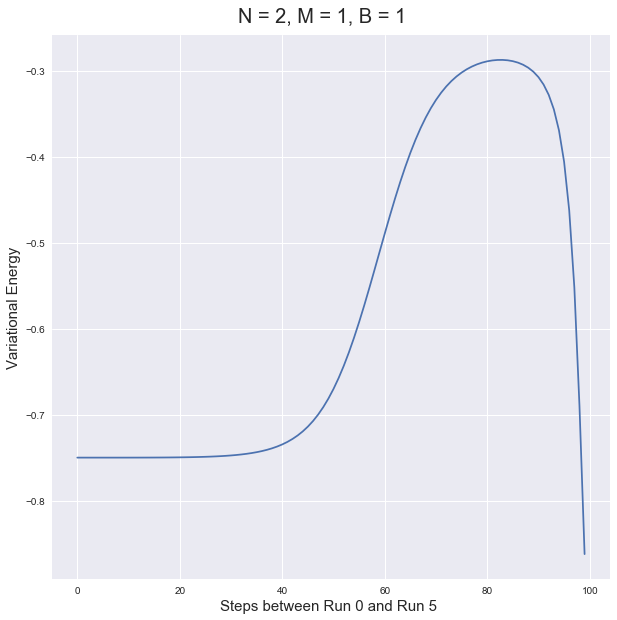

In [353]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, B = 1",size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.92])


ax4 = plt.subplot(gs[0, :])
ax4.plot(steps,engAlongMin) 
ax4 .set_ylabel("Variational Energy", size = 15)
ax4.set_xlabel("Steps between Run 0 and Run 5 ",size = 15)


In [334]:
ind = 5
x = np.arange(-10,11,0.1)

eng1 = []
for i in range(len(x)):
    param_it1 = list(trained_params[ind])
    param_it1[0] = x[i]
    varEng = varEnergy(param_it1,N, M, hamiltonian(N,B,A0))
    eng1.append(varEng)
    

eng2 = []
for i in range(len(x)):
    param_it2 = list(trained_params[ind])
    param_it2[1] = x[i]
    varEng = varEnergy(param_it2,N, M, hamiltonian(N,B,A0))
    eng2.append(varEng)
    

eng3 = []
for i in range(len(x)):
    param_it3 = list(trained_params[ind]) 
    param_it3[2] = x[i]
    varEng = varEnergy(param_it3,N, M, hamiltonian(N,B,A0))
    eng3.append(varEng)
    

eng4 = []
for i in range(len(x)):
    param_it4 = list(trained_params[ind])
    param_it4[3] = x[i]
    varEng = varEnergy(param_it4,N, M, hamiltonian(N,B,A0))
    eng4.append(varEng)

eng5 = []
for i in range(len(x)):
    param_it5 = list(trained_params[ind]) 
    param_it5[4] = x[i]
    varEng = varEnergy(param_it5,N, M, hamiltonian(N,B,A0))
    eng5.append(varEng)

eng6 = []
for i in range(len(x)):
    param_it6 = list(trained_params[ind]) 
    param_it6[5] = x[i]
    varEng = varEnergy(param_it6,N, M, hamiltonian(N,B,A0))
    eng6.append(varEng)


eng7 = []
for i in range(len(x)):
    param_it7 = list(trained_params[ind]) 
    param_it7[6] = x[i]
    varEng = varEnergy(param_it7,N, M, hamiltonian(N,B,A0))
    eng7.append(varEng)


eng8 = []
for i in range(len(x)):
    param_it8 = list(trained_params[ind]) 
    param_it8[7] = x[i]
    varEng = varEnergy(param_it8,N, M, hamiltonian(N,B,A0))
    eng8.append(varEng)

eng9 = []
for i in range(len(x)):
    param_it9 = list(trained_params[ind]) 
    param_it9[8] = x[i]
    varEng = varEnergy(param_it9,N, M, hamiltonian(N,B,A0))
    eng9.append(varEng)

eng10 = []
for i in range(len(x)):
    param_it10 = list(trained_params[ind]) 
    param_it10[9] = x[i]
    varEng = varEnergy(param_it10,N, M, hamiltonian(N,B,A0))
    eng10.append(varEng)

<Figure size 432x288 with 0 Axes>

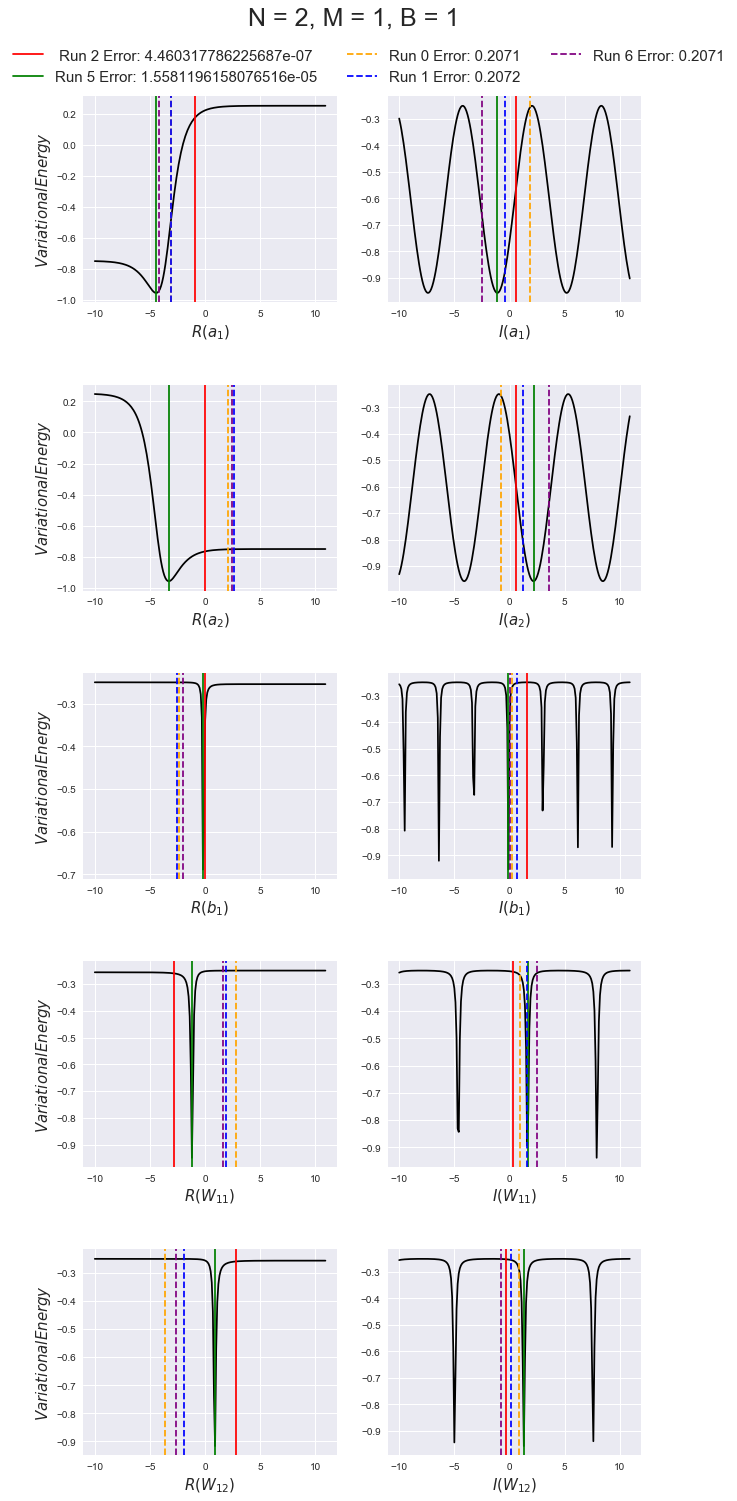

In [335]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,25))
ttl = plt.suptitle("N = 2, M = 1, B = 1\n",size =25)
gs = gridspec.GridSpec(ncols=2, nrows=5, hspace = 0.4)
ttl.set_position([.5, 0.93])

ind1 = 2
ind2 = 5 
ind3 = 0
ind4 = 1
ind5 = 6

lowErr = ' Run 2 Error: '+ str(gdEngErr[ind1]) 
highErr1 = 'Run 5 Error: '+ str(gdEngErr[ind2])#f"{gdEngErr[ind2]:.6f}"
highErr2 = 'Run 0 Error: '+ f"{gdEngErr[ind3]:.4f}"
highErr3 = 'Run 1 Error: '+ f"{gdEngErr[ind4]:.4f}"
highErr4 = 'Run 6 Error: '+ f"{gdEngErr[ind5]:.4f}"
labels = [lowErr,highErr1,highErr2, highErr3, highErr4]

ax1 = plt.subplot(gs[0,0])
ax1.plot(x,eng1,color ='black') 
a = ax1.axvline(trained_params[ind1][0],color ='r', label=labels[0])
b = ax1.axvline(trained_params[ind2][0],color ='g',label=labels[1])
c = ax1.axvline(trained_params[ind3][0],color ='orange', linestyle='dashed',label=labels[2])
d = ax1.axvline(trained_params[ind4][0],color ='b', linestyle='dashed',label=labels[3])
e = ax1.axvline(trained_params[ind5][0],color ='purple', linestyle='dashed',label=labels[4])
ax1 .set_ylabel("$Variational Energy$", size = 15)
ax1.set_xlabel("$R(a_1)$",size = 15)

ax2 = plt.subplot(gs[1,0])
ax2 .set_ylabel("$Variational Energy$", size = 15)
ax2.plot(x,eng2,color ='black')  
ax2.axvline(trained_params[ind1][1],color ='r')
ax2.axvline(trained_params[ind2][1],color ='g')
ax2.axvline(trained_params[ind3][1],color ='orange', linestyle='dashed')
ax2.axvline(trained_params[ind4][1],color ='b', linestyle='dashed')
ax2.axvline(trained_params[ind5][1],color ='purple', linestyle='dashed')
ax2.set_xlabel("$R(a_2)$",size = 15)

ax3 = plt.subplot(gs[2,0])
ax3 .set_ylabel("$Variational Energy$", size = 15)
ax3.plot(x,eng3,color ='black')  
ax3.axvline(trained_params[ind1][2],color ='r')
ax3.axvline(trained_params[ind2][2],color ='g')
ax3.axvline(trained_params[ind3][2],color ='orange', linestyle='dashed')
ax3.axvline(trained_params[ind4][2],color ='b', linestyle='dashed')
ax3.axvline(trained_params[ind5][2],color ='purple', linestyle='dashed')
ax3.set_xlabel("$R(b_1)$",size = 15)

ax4 = plt.subplot(gs[3,0])
ax4 .set_ylabel("$Variational Energy$", size = 15)
ax4.plot(x,eng4,color ='black')  
ax4.axvline(trained_params[ind1][3],color ='r')
ax4.axvline(trained_params[ind2][3],color ='g')
ax4.axvline(trained_params[ind3][3],color ='orange', linestyle='dashed')
ax4.axvline(trained_params[ind4][3],color ='b', linestyle='dashed')
ax4.axvline(trained_params[ind5][3],color ='purple', linestyle='dashed')
ax4.set_xlabel("$R(W_{11})$",size = 15)

ax5 = plt.subplot(gs[4,0])
ax5 .set_ylabel("$Variational Energy$", size = 15)
ax5.plot(x,eng5,color ='black') 
ax5.axvline(trained_params[ind1][4],color ='r')
ax5.axvline(trained_params[ind2][4],color ='g')
ax5.axvline(trained_params[ind3][4],color ='orange', linestyle='dashed')
ax5.axvline(trained_params[ind4][4],color ='b', linestyle='dashed')
ax5.axvline(trained_params[ind5][4],color ='purple', linestyle='dashed')
ax5.set_xlabel("$R(W_{12})$",size = 15)

ax6 = plt.subplot(gs[0,1])
ax6.plot(x,eng6,color ='black')  
ax6.axvline(trained_params[ind1][5],color ='r')
ax6.axvline(trained_params[ind2][5],color ='g')
ax6.axvline(trained_params[ind3][5],color ='orange', linestyle='dashed')
ax6.axvline(trained_params[ind4][5],color ='b', linestyle='dashed')
ax6.axvline(trained_params[ind5][5],color ='purple', linestyle='dashed')
ax6.set_xlabel("$I(a_1)$",size = 15)

ax7 = plt.subplot(gs[1,1])
ax7.plot(x,eng7,color ='black')  
ax7.axvline(trained_params[ind1][6],color ='r')
ax7.axvline(trained_params[ind2][6],color ='g')
ax7.axvline(trained_params[ind3][6],color ='orange', linestyle='dashed')
ax7.axvline(trained_params[ind4][6],color ='b', linestyle='dashed')
ax7.axvline(trained_params[ind5][6],color ='purple', linestyle='dashed')
ax7.set_xlabel("$I(a_2)$",size = 15)

ax8 = plt.subplot(gs[2,1])
ax8.plot(x,eng8,color ='black')  
ax8.axvline(trained_params[ind1][7],color ='r')
ax8.axvline(trained_params[ind2][7],color ='g')
ax8.axvline(trained_params[ind3][7],color ='orange', linestyle='dashed')
ax8.axvline(trained_params[ind4][7],color ='b', linestyle='dashed')
ax8.axvline(trained_params[ind5][7],color ='purple', linestyle='dashed')
ax8.set_xlabel("$I(b_1)$",size = 15)

ax9 = plt.subplot(gs[3,1])
ax9.plot(x,eng9,color ='black') 
ax9.axvline(trained_params[ind1][8],color ='r')
ax9.axvline(trained_params[ind2][8],color ='g')
ax9.axvline(trained_params[ind3][8],color ='orange', linestyle='dashed')
ax9.axvline(trained_params[ind4][8],color ='b', linestyle='dashed')
ax9.axvline(trained_params[ind5][8],color ='purple', linestyle='dashed')
ax9.set_xlabel("$I(W_{11})$",size = 15)

ax10 = plt.subplot(gs[4,1])
ax10.plot(x,eng10,color ='black')  
ax10.axvline(trained_params[ind1][9],color ='r')
ax10.axvline(trained_params[ind2][9],color ='g')
ax10.axvline(trained_params[ind3][9],color ='orange', linestyle='dashed')
ax10.axvline(trained_params[ind4][9],color ='b', linestyle='dashed')
ax10.axvline(trained_params[ind5][9],color ='purple', linestyle='dashed')
ax10.set_xlabel("$I(W_{12})$",size = 15)

plt.legend(handles = [a, b,c,d,e], loc = (-1.5, 6.63),fontsize = 15,ncol=3)

In [357]:
zeroVector = [0,0,0,0,0,0,0,0,0,0]
x = np.arange(-10,11,0.1)

eng1 = []
for i in range(len(x)):
    param_it1 = list(zeroVector)
    param_it1[0] = x[i]
    varEng = varEnergy(param_it1,N, M, hamiltonian(N,B,A0))
    eng1.append(varEng)
    

eng2 = []
for i in range(len(x)):
    param_it2 = list(zeroVector)
    param_it2[1] = x[i]
    varEng = varEnergy(param_it2,N, M, hamiltonian(N,B,A0))
    eng2.append(varEng)
    

eng3 = []
for i in range(len(x)):
    param_it3 = list(zeroVector) 
    param_it3[2] = x[i]
    varEng = varEnergy(param_it3,N, M, hamiltonian(N,B,A0))
    eng3.append(varEng)
    

eng4 = []
for i in range(len(x)):
    param_it4 = list(zeroVector)
    param_it4[3] = x[i]
    varEng = varEnergy(param_it4,N, M, hamiltonian(N,B,A0))
    eng4.append(varEng)

eng5 = []
for i in range(len(x)):
    param_it5 = list(zeroVector) 
    param_it5[4] = x[i]
    varEng = varEnergy(param_it5,N, M, hamiltonian(N,B,A0))
    eng5.append(varEng)

eng6 = []
for i in range(len(x)):
    param_it6 = list(zeroVector) 
    param_it6[5] = x[i]
    varEng = varEnergy(param_it6,N, M, hamiltonian(N,B,A0))
    eng6.append(varEng)


eng7 = []
for i in range(len(x)):
    param_it7 = list(zeroVector) 
    param_it7[6] = x[i]
    varEng = varEnergy(param_it7,N, M, hamiltonian(N,B,A0))
    eng7.append(varEng)


eng8 = []
for i in range(len(x)):
    param_it8 = list(zeroVector) 
    param_it8[7] = x[i]
    varEng = varEnergy(param_it8,N, M, hamiltonian(N,B,A0))
    eng8.append(varEng)

eng9 = []
for i in range(len(x)):
    param_it9 = list(zeroVector) 
    param_it9[8] = x[i]
    varEng = varEnergy(param_it9,N, M, hamiltonian(N,B,A0))
    eng9.append(varEng)

eng10 = []
for i in range(len(x)):
    param_it10 = list(zeroVector) 
    param_it10[9] = x[i]
    varEng = varEnergy(param_it10,N, M, hamiltonian(N,B,A0))
    eng10.append(varEng)

<Figure size 432x288 with 0 Axes>

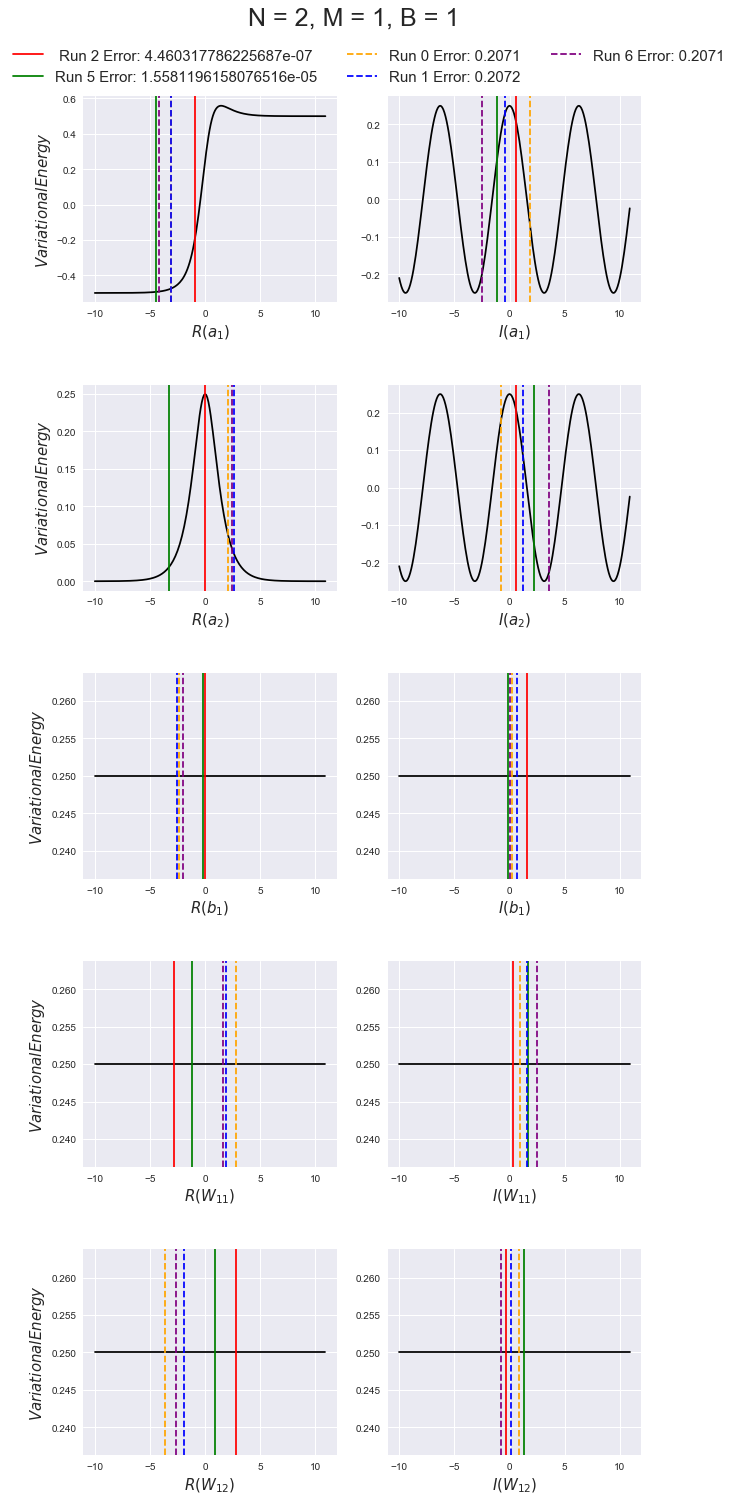

In [359]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,25))
ttl = plt.suptitle("N = 2, M = 1, B = 1\n",size =25)
gs = gridspec.GridSpec(ncols=2, nrows=5, hspace = 0.4)
ttl.set_position([.5, 0.93])

ind1 = 2
ind2 = 5 
ind3 = 0
ind4 = 1
ind5 = 6

lowErr = ' Run 2 Error: '+ str(gdEngErr[ind1]) 
highErr1 = 'Run 5 Error: '+ str(gdEngErr[ind2])#f"{gdEngErr[ind2]:.6f}"
highErr2 = 'Run 0 Error: '+ f"{gdEngErr[ind3]:.4f}"
highErr3 = 'Run 1 Error: '+ f"{gdEngErr[ind4]:.4f}"
highErr4 = 'Run 6 Error: '+ f"{gdEngErr[ind5]:.4f}"
labels = [lowErr,highErr1,highErr2, highErr3, highErr4]

ax1 = plt.subplot(gs[0,0])
ax1.plot(x,eng1,color ='black') 
a = ax1.axvline(trained_params[ind1][0],color ='r', label=labels[0])
b = ax1.axvline(trained_params[ind2][0],color ='g',label=labels[1])
c = ax1.axvline(trained_params[ind3][0],color ='orange', linestyle='dashed',label=labels[2])
d = ax1.axvline(trained_params[ind4][0],color ='b', linestyle='dashed',label=labels[3])
e = ax1.axvline(trained_params[ind5][0],color ='purple', linestyle='dashed',label=labels[4])
ax1 .set_ylabel("$Variational Energy$", size = 15)
ax1.set_xlabel("$R(a_1)$",size = 15)

ax2 = plt.subplot(gs[1,0])
ax2 .set_ylabel("$Variational Energy$", size = 15)
ax2.plot(x,eng2,color ='black')  
ax2.axvline(trained_params[ind1][1],color ='r')
ax2.axvline(trained_params[ind2][1],color ='g')
ax2.axvline(trained_params[ind3][1],color ='orange', linestyle='dashed')
ax2.axvline(trained_params[ind4][1],color ='b', linestyle='dashed')
ax2.axvline(trained_params[ind5][1],color ='purple', linestyle='dashed')
ax2.set_xlabel("$R(a_2)$",size = 15)

ax3 = plt.subplot(gs[2,0])
ax3 .set_ylabel("$Variational Energy$", size = 15)
ax3.plot(x,eng3,color ='black')  
ax3.axvline(trained_params[ind1][2],color ='r')
ax3.axvline(trained_params[ind2][2],color ='g')
ax3.axvline(trained_params[ind3][2],color ='orange', linestyle='dashed')
ax3.axvline(trained_params[ind4][2],color ='b', linestyle='dashed')
ax3.axvline(trained_params[ind5][2],color ='purple', linestyle='dashed')
ax3.set_xlabel("$R(b_1)$",size = 15)

ax4 = plt.subplot(gs[3,0])
ax4 .set_ylabel("$Variational Energy$", size = 15)
ax4.plot(x,eng4,color ='black')  
ax4.axvline(trained_params[ind1][3],color ='r')
ax4.axvline(trained_params[ind2][3],color ='g')
ax4.axvline(trained_params[ind3][3],color ='orange', linestyle='dashed')
ax4.axvline(trained_params[ind4][3],color ='b', linestyle='dashed')
ax4.axvline(trained_params[ind5][3],color ='purple', linestyle='dashed')
ax4.set_xlabel("$R(W_{11})$",size = 15)

ax5 = plt.subplot(gs[4,0])
ax5 .set_ylabel("$Variational Energy$", size = 15)
ax5.plot(x,eng5,color ='black') 
ax5.axvline(trained_params[ind1][4],color ='r')
ax5.axvline(trained_params[ind2][4],color ='g')
ax5.axvline(trained_params[ind3][4],color ='orange', linestyle='dashed')
ax5.axvline(trained_params[ind4][4],color ='b', linestyle='dashed')
ax5.axvline(trained_params[ind5][4],color ='purple', linestyle='dashed')
ax5.set_xlabel("$R(W_{12})$",size = 15)

ax6 = plt.subplot(gs[0,1])
ax6.plot(x,eng6,color ='black')  
ax6.axvline(trained_params[ind1][5],color ='r')
ax6.axvline(trained_params[ind2][5],color ='g')
ax6.axvline(trained_params[ind3][5],color ='orange', linestyle='dashed')
ax6.axvline(trained_params[ind4][5],color ='b', linestyle='dashed')
ax6.axvline(trained_params[ind5][5],color ='purple', linestyle='dashed')
ax6.set_xlabel("$I(a_1)$",size = 15)

ax7 = plt.subplot(gs[1,1])
ax7.plot(x,eng7,color ='black')  
ax7.axvline(trained_params[ind1][6],color ='r')
ax7.axvline(trained_params[ind2][6],color ='g')
ax7.axvline(trained_params[ind3][6],color ='orange', linestyle='dashed')
ax7.axvline(trained_params[ind4][6],color ='b', linestyle='dashed')
ax7.axvline(trained_params[ind5][6],color ='purple', linestyle='dashed')
ax7.set_xlabel("$I(a_2)$",size = 15)

ax8 = plt.subplot(gs[2,1])
ax8.plot(x,eng8,color ='black')  
ax8.axvline(trained_params[ind1][7],color ='r')
ax8.axvline(trained_params[ind2][7],color ='g')
ax8.axvline(trained_params[ind3][7],color ='orange', linestyle='dashed')
ax8.axvline(trained_params[ind4][7],color ='b', linestyle='dashed')
ax8.axvline(trained_params[ind5][7],color ='purple', linestyle='dashed')
ax8.set_xlabel("$I(b_1)$",size = 15)

ax9 = plt.subplot(gs[3,1])
ax9.plot(x,eng9,color ='black') 
ax9.axvline(trained_params[ind1][8],color ='r')
ax9.axvline(trained_params[ind2][8],color ='g')
ax9.axvline(trained_params[ind3][8],color ='orange', linestyle='dashed')
ax9.axvline(trained_params[ind4][8],color ='b', linestyle='dashed')
ax9.axvline(trained_params[ind5][8],color ='purple', linestyle='dashed')
ax9.set_xlabel("$I(W_{11})$",size = 15)

ax10 = plt.subplot(gs[4,1])
ax10.plot(x,eng10,color ='black')  
ax10.axvline(trained_params[ind1][9],color ='r')
ax10.axvline(trained_params[ind2][9],color ='g')
ax10.axvline(trained_params[ind3][9],color ='orange', linestyle='dashed')
ax10.axvline(trained_params[ind4][9],color ='b', linestyle='dashed')
ax10.axvline(trained_params[ind5][9],color ='purple', linestyle='dashed')
ax10.set_xlabel("$I(W_{12})$",size = 15)

plt.legend(handles = [a, b,c,d,e], loc = (-1.5, 6.63),fontsize = 15,ncol=3)

In [49]:
zeroVector = [2,0,0,0,0,0,0,0,0,0]
H=hamiltonian(N,B,A0)
print(H)
psiM = RBM_ansatz(zeroVector,N, M)
print(psiM)
E = expect(H,psiM)
print(E)
norm = psiM.norm()**2
print(norm)
Enorm = E/norm
print(Enorm)
varEnergy(zeroVector,N, M, H)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.75  0.    0.    0.  ]
 [ 0.    0.25  0.5   0.  ]
 [ 0.    0.5  -0.75  0.  ]
 [ 0.    0.    0.   -0.25]]
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[5.43656366]
 [5.43656366]
 [0.73575888]
 [0.73575888]]
33.014883262776145
60.195131057338095
0.5484643472464283


0.5484643472464283

## Distances


In [200]:
#Parameter definition 
N= 2
M=1
B = 1
A0 = 1


gdResults = [] #gives ground state estimation at each iteration of gd
gdState = []
gdTime = []
gdEngErr = []
gdStateErr = []

params = []
trained_params = []

edState = []
edTime = []
ActualEng = []
hisIt = np.arange(20)

In [201]:
for i in range(20):
    par = ranRBMpar(N,M)
    params.append(par)
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M,par)
    gdResults.append(gd)
    gdState.append(gd[0])
    gdTime.append(gd[1])
    trained_params.append(gd[0][0][0])


    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    edState.append(ed[0])
    edTime.append(ed[1])

    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    gdErrTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    gdEngErr.append(gdErrTemp[0])
    gdStateErr.append(gdErrTemp[1])

Optimization terminated successfully.
         Current function value: -0.749963
         Iterations: 10
         Function evaluations: 420
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 18
         Function evaluations: 444
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: -0.749963
         Iterations: 4
         Function evaluations: 240
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -0.749953
         Iterations: 5
         Function evaluations: 240
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -0.957102
         Iterations: 29
         Function evaluations: 552
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: -0.957080
         Iterations: 33
         Function evaluatio

Text(0.5, 0, 'Run Number')

<Figure size 432x288 with 0 Axes>

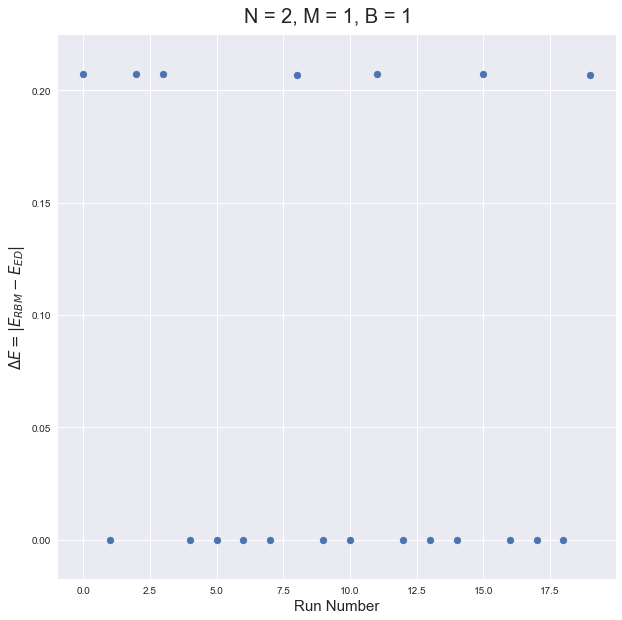

In [202]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, B = 1",size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.92])


ax4 = plt.subplot(gs[0, :])
ax4.scatter(hisIt,gdEngErr) 
ax4 .set_ylabel("$\Delta E = |E_{RBM}-E_{ED}|$", size = 15)
ax4.set_xlabel("Run Number",size = 15)


In [203]:
gdEngErrSort = np.sort(gdEngErr)
order = list(np.arange(len(gdEngErr)))
print(gdEngErr)
print(gdEngErr)

[0.2071438941053465, 2.027714995911367e-09, 0.20714383212026222, 0.20715370079912088, 4.3447835614829344e-06, 2.6642796365661248e-05, 2.1905950386980066e-09, 2.6624853772805324e-06, 0.20707773131524276, 1.3233620226871246e-05, 9.38158201158057e-06, 0.20716695338604596, 1.1053249956538558e-05, 1.0117472294290941e-05, 1.3616508365288382e-08, 0.20710940073024597, 2.294209462516683e-06, 2.9889292596951833e-05, 2.835231616149514e-08, 0.20710692897140692]
[0.2071438941053465, 2.027714995911367e-09, 0.20714383212026222, 0.20715370079912088, 4.3447835614829344e-06, 2.6642796365661248e-05, 2.1905950386980066e-09, 2.6624853772805324e-06, 0.20707773131524276, 1.3233620226871246e-05, 9.38158201158057e-06, 0.20716695338604596, 1.1053249956538558e-05, 1.0117472294290941e-05, 1.3616508365288382e-08, 0.20710940073024597, 2.294209462516683e-06, 2.9889292596951833e-05, 2.835231616149514e-08, 0.20710692897140692]


In [204]:
paramsSort = []
trained_paramsSort = []
for i in range(len(gdEngErrSort)):
    for j in range(len(gdEngErrSort)):
        if (gdEngErrSort[i]==gdEngErr[j]):
                trained_paramsSort.append(trained_params[j])
                paramsSort.append(params[j])
                
paramsSortNorm = []
trained_paramsSortNorm = []
for i in range(len(gdEngErrSort)):
    paramsSortNorm.append(np.linalg.norm(paramsSort[i]))
    trained_paramsSortNorm.append(np.linalg.norm(trained_paramsSort[i]))
    
param0 = [item[0] for item in paramsSort]
param1 = [item[1] for item in paramsSort]
param2 = [item[2] for item in paramsSort]
param3 = [item[3] for item in paramsSort]
param4 = [item[4] for item in paramsSort]
param5 = [item[5] for item in paramsSort]
param6 = [item[6] for item in paramsSort]
param7 = [item[7] for item in paramsSort]
param8 = [item[8] for item in paramsSort]
param9 = [item[9] for item in paramsSort]

trained_param0 = [item[0] for item in trained_paramsSort]
trained_param1 = [item[1] for item in trained_paramsSort]
trained_param2 = [item[2] for item in trained_paramsSort]
trained_param3 = [item[3] for item in trained_paramsSort]
trained_param4 = [item[4] for item in trained_paramsSort]
trained_param5 = [item[5] for item in trained_paramsSort]
trained_param6 = [item[6] for item in trained_paramsSort]
trained_param7 = [item[7] for item in trained_paramsSort]
trained_param8 = [item[8] for item in trained_paramsSort]
trained_param9 = [item[9] for item in trained_paramsSort]



In [245]:
#Correlation
trained_param0Mean = np.mean(trained_param0)
trained_param1Mean = np.mean(trained_param1)
trained_param2Mean = np.mean(trained_param2)
trained_param3Mean = np.mean(trained_param3)
trained_param4Mean = np.mean(trained_param4)
trained_param5Mean = np.mean(trained_param5)
trained_param6Mean = np.mean(trained_param6)
trained_param7Mean = np.mean(trained_param7)
trained_param8Mean = np.mean(trained_param8)
trained_param9Mean = np.mean(trained_param9)
gdEngErrSortMean = np.mean(gdEngErrSort)

engSub = gdEngErrSort - gdEngErrSortMean
trained_param0Sub = trained_param0 - trained_param0Mean
trained_param1Sub = trained_param1 - trained_param1Mean
trained_param2Sub = trained_param2 - trained_param2Mean
trained_param3Sub = trained_param3 - trained_param3Mean
trained_param4Sub = trained_param4 - trained_param4Mean
trained_param5Sub = trained_param5 - trained_param5Mean
trained_param6Sub = trained_param6 - trained_param6Mean
trained_param7Sub = trained_param7 - trained_param7Mean
trained_param8Sub = trained_param8 - trained_param8Mean
trained_param9Sub = trained_param9 - trained_param9Mean


corr0 = np.sum(trained_param0Sub*engSub)/ np.sqrt((np.sum(trained_param0Sub**2))*(np.sum(engSub**2)))
corr1 = np.sum(trained_param1Sub*engSub)/ np.sqrt((np.sum(trained_param1Sub**2))*(np.sum(engSub**2)))
corr2 = np.sum(trained_param2Sub*engSub)/ np.sqrt((np.sum(trained_param2Sub**2))*(np.sum(engSub**2)))
corr3 = np.sum(trained_param3Sub*engSub)/ np.sqrt((np.sum(trained_param3Sub**2))*(np.sum(engSub**2)))
corr4 = np.sum(trained_param4Sub*engSub)/ np.sqrt((np.sum(trained_param4Sub**2))*(np.sum(engSub**2)))
corr5 = np.sum(trained_param5Sub*engSub)/ np.sqrt((np.sum(trained_param5Sub**2))*(np.sum(engSub**2)))
corr6 = np.sum(trained_param6Sub*engSub)/ np.sqrt((np.sum(trained_param6Sub**2))*(np.sum(engSub**2)))
corr7 = np.sum(trained_param7Sub*engSub)/ np.sqrt((np.sum(trained_param7Sub**2))*(np.sum(engSub**2)))
corr8 = np.sum(trained_param8Sub*engSub)/ np.sqrt((np.sum(trained_param8Sub**2))*(np.sum(engSub**2)))
corr9 = np.sum(trained_param9Sub*engSub)/ np.sqrt((np.sum(trained_param9Sub**2))*(np.sum(engSub**2)))



<Figure size 432x288 with 0 Axes>

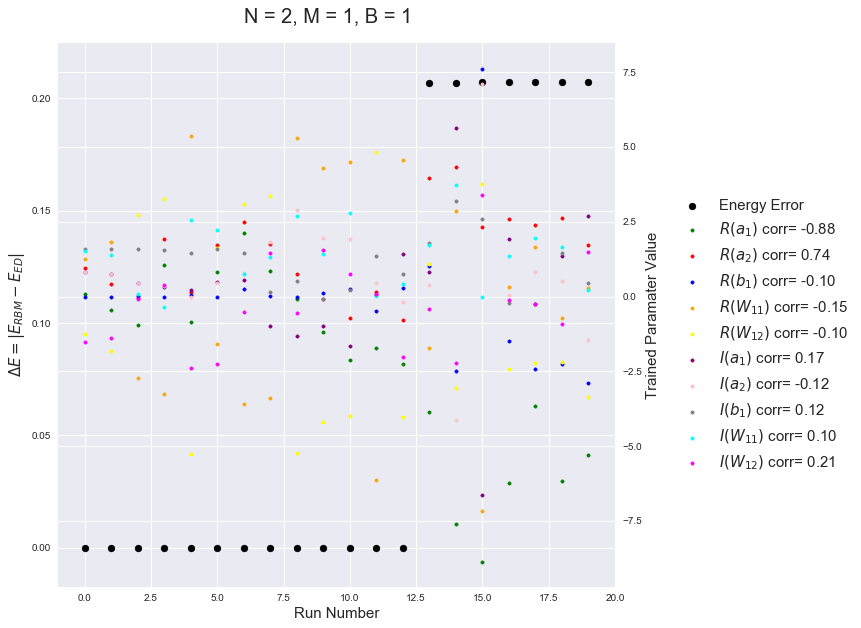

In [265]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, B = 1",size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.93])

labels = ["Energy Error","$R(a_1)$ corr= "+f"{corr0:.2f}" ,"$R(a_2)$ corr= "+f"{corr1:.2f}","$R(b_1)$ corr= "+f"{corr2:.2f}","$R(W_{11})$ corr= "+f"{corr3:.2f}","$R(W_{12})$ corr= "+f"{corr4:.2f}","$I(a_1)$ corr= "+f"{corr5:.2f}","$I(a_2)$ corr= "+f"{corr6:.2f}","$I(b_1)$ corr= "+f"{corr7:.2f}","$I(W_{11})$ corr= "+f"{corr8:.2f}","$I(W_{12})$ corr= "+f"{corr9:.2f}"]


ax4 = plt.subplot(gs[0, :])
a = ax4.scatter(hisIt,gdEngErrSort, color='black', label=labels[0]) 
ax4 .set_ylabel("$\Delta E = |E_{RBM}-E_{ED}|$", size = 15)
ax4.set_xlabel("Run Number",size = 15)

ax5 = ax4.twinx()
color = 'tab:blue'
#ax5.scatter(hisIt,paramsSortNorm, color='green') 
#ax5.scatter(hisIt,trained_paramsSortNorm, color=color) 
b = ax5.scatter(hisIt,trained_param0, color='green',marker=".", label=labels[1]) 
c = ax5.scatter(hisIt,trained_param1, color='red',marker=".", label=labels[2])
d = ax5.scatter(hisIt,trained_param2, color='blue',marker=".", label=labels[3])
e = ax5.scatter(hisIt,trained_param3, color='orange',marker=".", label=labels[4])
f = ax5.scatter(hisIt,trained_param4, color='yellow',marker=".", label=labels[5])
g = ax5.scatter(hisIt,trained_param5, color='purple',marker=".", label=labels[6])
h = ax5.scatter(hisIt,trained_param6, color='pink',marker=".", label=labels[7])
i = ax5.scatter(hisIt,trained_param7, color='gray',marker=".", label=labels[8])
j = ax5.scatter(hisIt,trained_param8, color='cyan',marker=".", label=labels[9])
k = ax5.scatter(hisIt,trained_param9, color='magenta',marker=".", label=labels[10])
ax5.set_ylabel("Trained Paramater Value", size = 15)
ax5.set_xlabel("Run Number",size = 15)
plt.legend(handles = [a, b,c,d,e,f,g,h,i,j,k], loc = (1.1,.2),fontsize = 15,ncol=1)

